In [3]:
!pip install statsmodels

     ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
      --------------------------------------- 0.1/9.6 MB 8.3 MB/s eta 0:00:02
     --- ------------------------------------ 0.8/9.6 MB 12.2 MB/s eta 0:00:01
     ----- ---------------------------------- 1.3/9.6 MB 13.8 MB/s eta 0:00:01
     ----- ---------------------------------- 1.3/9.6 MB 13.8 MB/s eta 0:00:01
     ----- ---------------------------------- 1.3/9.6 MB 13.8 MB/s eta 0:00:01
     ----- ---------------------------------- 1.3/9.6 MB 13.8 MB/s eta 0:00:01
     ----- ---------------------------------- 1.3/9.6 MB 13.8 MB/s eta 0:00:01
     ----- ---------------------------------- 1.3/9.6 MB 13.8 MB/s eta 0:00:01
     ----------- ---------------------------- 2.7/9.6 MB 6.8 MB/s eta 0:00:02
     -------------- ------------------------- 3.5/9.6 MB 8.2 MB/s eta 0:00:01
     -------------------- ------------------- 4.8/9.6 MB 9.9 MB/s eta 0:00:01
     ----------------------- ---------------- 5.7/9.6 MB 10.7 MB


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: C:\Users\Aryan\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [5]:
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid') 

[*********************100%***********************]  2 of 2 completed


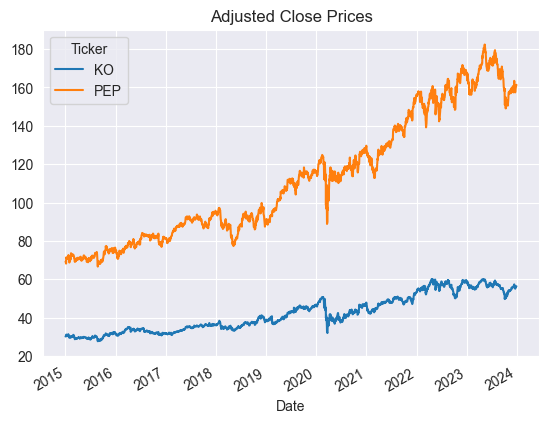

In [13]:
tickers = ['KO', 'PEP']  # Coca-Cola and Pepsi
start_date = '2015-01-01'
end_date = '2023-12-31'

data = yf.download(tickers, start=start_date, end=end_date)['Close']
data = data.dropna()
data.plot(title='Adjusted Close Prices')
plt.show()

In [14]:
score, pvalue, _ = coint(data['KO'], data['PEP'])
print(f'Cointegration p-value: {pvalue:.4f}')

Cointegration p-value: 0.0095


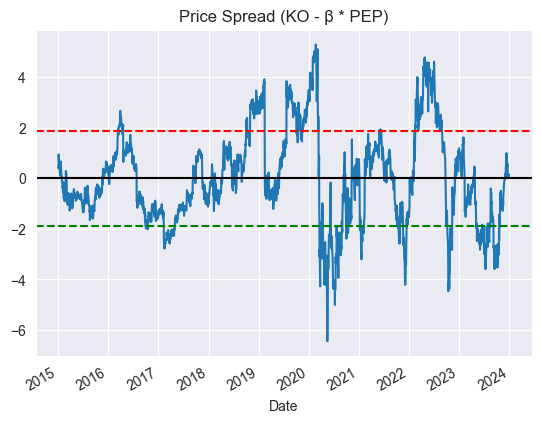

In [15]:
X = sm.add_constant(data['PEP'])
model = sm.OLS(data['KO'], X).fit()
spread = data['KO'] - model.predict(X)

spread.plot(title='Price Spread (KO - β * PEP)')
plt.axhline(spread.mean(), color='black')
plt.axhline(spread.mean() + spread.std(), color='red', linestyle='--')
plt.axhline(spread.mean() - spread.std(), color='green', linestyle='--')
plt.show()


In [16]:
zscore = (spread - spread.mean()) / spread.std()

entry_z = 2
exit_z = 0

signals = pd.DataFrame(index=data.index)
signals['zscore'] = zscore
signals['long'] = (zscore < -entry_z).astype(int)
signals['short'] = (zscore > entry_z).astype(int)
signals['exit'] = (abs(zscore) < exit_z).astype(int)
signals.tail()

,zscore,long,short,exit
Date,,,,
2023-12-22,0.080063,0,0,0
2023-12-26,0.031156,0,0,0
2023-12-27,0.029248,0,0,0
2023-12-28,0.051085,0,0,0
2023-12-29,0.077529,0,0,0


In [17]:
positions = pd.DataFrame(index=signals.index)
positions['KO'] = 0
positions['PEP'] = 0

long_signal = signals['long'] == 1
short_signal = signals['short'] == 1
exit_signal = signals['exit'] == 1

position = 0  # 1 for long KO/short PEP, -1 for short KO/long PEP

for i in range(1, len(signals)):
    if long_signal[i]:
        position = 1
    elif short_signal[i]:
        position = -1
    elif exit_signal[i]:
        position = 0
    positions.iloc[i] = position

positions['KO'] *= 1
positions['PEP'] = -positions['KO'] * model.params['PEP']


C:\Users\Aryan\AppData\Local\Temp\ipykernel_37444\1846382860.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if long_signal[i]:
C:\Users\Aryan\AppData\Local\Temp\ipykernel_37444\1846382860.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif short_signal[i]:
C:\Users\Aryan\AppData\Local\Temp\ipykernel_37444\1846382860.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif exit_signal[i]:


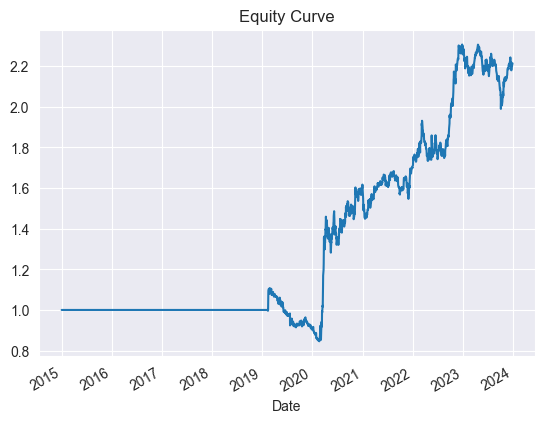

In [18]:
daily_returns = data.pct_change().dropna()
strategy_returns = (positions.shift() * daily_returns).sum(axis=1)

equity_curve = (1 + strategy_returns).cumprod()
equity_curve.plot(title='Equity Curve')
plt.show()


In [20]:
def sharpe_ratio(returns, freq=252):
    return np.sqrt(freq) * returns.mean() / returns.std()

def max_drawdown(equity):
    roll_max = equity.cummax()
    drawdown = equity / roll_max - 1.0
    return drawdown.min()

print(f"Sharpe Ratio: {sharpe_ratio(strategy_returns):.2f}")
print(f"Max Drawdown: {max_drawdown(equity_curve):.2%}")
# print(f"Cumulative Return: {equity_curve[-1] - 1:.2%}")
print(f"Cumulative Return: {equity_curve.iloc[-1] - 1:.2%}")


Sharpe Ratio: 0.76
Max Drawdown: -23.61%
Cumulative Return: 121.34%
